In [4]:
!git clone https://github.com/TiwariShivam333/Material-Recognition

Cloning into 'Material-Recognition'...
remote: Enumerating objects: 412, done.
remote: Total 412 (delta 0), reused 0 (delta 0), pack-reused 412
Receiving objects: 100% (412/412), 14.07 MiB | 43.39 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [0]:
import numpy as np
import pandas as pd
from tensorflow.python.lib.io import file_io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping, Callback
from google.colab.patches import cv2_imshow
import h5py
import cv2
import os
from tqdm import tqdm
from random import shuffle

In [0]:
classes = 4
img_height = 150
img_width = 150
epochs_all_layers = 100
batch_size = 32

In [142]:
file_paths = ["Material-Recognition/metal/","Material-Recognition/leather/","Material-Recognition/wood/","Material-Recognition/glass/"]
training_data = []
label = -1
for file_path in file_paths:
  label = label + 1
  for img in tqdm(os.listdir(file_path)):
    path = os.path.join(file_path,img)
    image = cv2.imread(path)
    image = cv2.resize(image, (img_height, img_width))
    training_data.append([np.array(image),np.array(label)])

100%|██████████| 100/100 [00:00<00:00, 425.07it/s]


In [0]:
dataset = training_data
dataset = np.array(dataset)
features = dataset[:, 0]
labels = dataset[:, 1]
labels_one_hot_encoded = to_categorical(labels, classes)

In [0]:
feature =[]
for i in range(len(features)):
    feature.append(features[i])

features = np.asarray(feature)
x_train, x_test, y_train, y_test= train_test_split(features, labels_one_hot_encoded, test_size = 0.30, stratify = labels_one_hot_encoded)

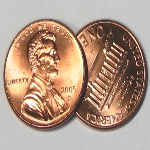

[1. 0. 0. 0.]


In [145]:
cv2_imshow(x_train[20])
print(y_train[20])

In [146]:
base_model = InceptionV3(include_top = False,weights = 'imagenet',input_shape=(img_height,img_width,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(classes, activation = 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_377 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_377 (BatchN (None, 74, 74, 32)   96          conv2d_377[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 74, 74, 32)   0           batch_normalization_377[0][0]    
__________________________________________________________________________________________________
conv2d_378

In [0]:
train_datagen = ImageDataGenerator(rotation_range=10,shear_range= 10,zoom_range = 0.1,fill_mode ='reflect',horizontal_flip = True)

In [0]:
train_generator = train_datagen.flow(x_train,y_train,batch_size  = batch_size)

In [0]:
for layer in model.layers:
    layer.trainable = True
    
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [150]:
%%time
model.fit_generator(generator = train_generator,steps_per_epoch = len(x_train) // 32,epochs = 25,
    validation_data =(x_test, y_test))

Epoch 1/25
8/8 [==============================] - 41s 5s/step - loss: 2.3487 - acc: 0.3398 - val_loss: 7.0216 - val_acc: 0.2750
Epoch 2/25
8/8 [==============================] - 1s 183ms/step - loss: 1.5682 - acc: 0.5996 - val_loss: 4.6657 - val_acc: 0.4250
Epoch 3/25
8/8 [==============================] - 1s 187ms/step - loss: 1.3620 - acc: 0.6321 - val_loss: 5.3048 - val_acc: 0.4583
Epoch 4/25
8/8 [==============================] - 1s 186ms/step - loss: 0.9881 - acc: 0.7599 - val_loss: 4.3413 - val_acc: 0.5250
Epoch 5/25
8/8 [==============================] - 1s 187ms/step - loss: 0.9422 - acc: 0.7920 - val_loss: 4.6134 - val_acc: 0.4583
Epoch 6/25
8/8 [==============================] - 2s 212ms/step - loss: 0.9714 - acc: 0.8190 - val_loss: 3.5188 - val_acc: 0.5333
Epoch 7/25
8/8 [==============================] - 2s 228ms/step - loss: 0.9684 - acc: 0.8021 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 8/25
8/8 [==============================] - 2s 202ms/step - loss: 0.9565 - acc: 0.762

In [151]:
model_json = model.to_json()
with open("material_recognition.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("material_recognition.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
y_pred = model.predict(x_test)

In [153]:
from keras.models import model_from_json
json_file = open("material_recognition.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("material_recognition.h5")
print("Loaded model from disk")

Loaded model from disk


In [0]:
classes1 = ['metal','leather','wood','glass']
loaded_model.compile(optimizer   = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

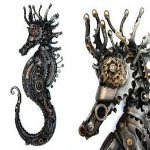

In [158]:
image = cv2.imread("2.jpeg")#("Material-Recognition/metal/wood_moderate_046_new.jpg")
image = cv2.resize(image, (img_height, img_width)) 
cv2_imshow(image)

In [159]:
%%time
result = (loaded_model.predict(np.array([image])))
print(classes1[result[0].argmax()])

glass
CPU times: user 26.1 ms, sys: 7.04 ms, total: 33.1 ms
Wall time: 34.2 ms
